# EE5907 CA2 Face Recognition
> by SS47816

## 0. Organize Dataset
From the original PIE dataset and my own photos:
1. Sample 25 subjects randomly + my own (26 classes in total)
2. Split the images into a training set and a test set (70/30 percent)

In [1]:
import os
import random
import shutil
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'cv2'

In [1]:
def splitPIEDataset(dataset_path, train_set_path, test_set_path) ->  None:
    """
    Split the PIE dataset into train and test sets

    Parameters
    ---
    `dataset_path`: `string`, path to the PIE dataset
    `train_set_path`: `string`, path to the output train set
    `test_set_path`: `string`, path to the output test set

    Returns
    ---
    `None`
    """

    # Remove old folders at the destination (if any)
    try:
        shutil.rmtree(train_set_path)
        shutil.rmtree(test_set_path)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))
    # Create destination folders
    os.mkdir(train_set_path)
    os.mkdir(test_set_path)

    # Select 25 from the 68 subjects
    selected_subjects = random.sample(os.listdir(dataset_path), 25)

    # Within each subject, split into 70-30 train-test set
    for subject_path in selected_subjects:
        if subject_path == '.DS_Store':
            continue
        img_paths = os.listdir(os.path.join(dataset_path, subject_path))
        
        # Split img file into train/test sets
        train_set = random.sample(img_paths, int(len(img_paths)*0.7))
        test_set = [item for item in img_paths if item not in train_set]
        
        # Copy files to new dataset folders
        src = os.path.join(dataset_path, subject_path)
        
        train_subject_path = os.path.join(train_set_path, subject_path)
        os.mkdir(train_subject_path)
        for img_file in train_set:
            print(os.path.join(src, img_file))
            print(train_subject_path)
            shutil.copy2(os.path.join(src, img_file), train_subject_path)
        
        test_subject_path = os.path.join(test_set_path, subject_path)
        os.mkdir(test_subject_path)
        for img_file in test_set:
            print(os.path.join(src, img_file))
            print(test_subject_path)
            shutil.copy2(os.path.join(src, img_file), test_subject_path)

def convertRGB2BW(folder_path) ->  None:
    """
    Convert color imgs in `folder_path` to binary imgs

    Parameters
    ---
    `folder_path`: `string`, path to directory

    Returns
    ---
    `None`
    """
    img_files = os.listdir(folder_path)
    for img_file in img_files:
        img = cv2.imread(os.path.join(folder_path, img_file), cv2.IMREAD_GRAYSCALE)
        cv2.imwrite(os.path.join(folder_path, img_file), img)

    print('Color convertion done!')
    

In [ ]:
# Define paths to the original PIE dataset and my_photo (please modify)
repo_path = '/home/ss/ss_ws/face-recognition'
my_photo_path = os.path.join(repo_path, 'data/my_photo')
# Define destination paths
dataset_path = os.path.join(repo_path, 'data/PIE')
train_set_path = os.path.join(repo_path, 'data/train')
test_set_path = os.path.join(repo_path, 'data/test')

# Convert color imgs in `/my_photo` to binary
# convertRGB2BW(my_photo_path)

# Part II, Split the PIE dataset into train and test sets
# splitPIEDataset(dataset_path, train_set_path, test_set_path)

## 0.5 Read the Dataset we just created

In [6]:
def readImageData(data_path, set='train', num_PIE_imgs=-1) -> tuple:
    """
    Read the PIE dataset and my_photo dataset

    Parameters
    ---
    `data_path`: `string`, path to the data folder
    `set`: `string`, can be either `train` or `test`
    `num_PIE_imgs`: `int`, number of PIE images to sample

    Returns
    ---
    `selected_PIE_imgs`: `np.ndarray`, a tensor made of vertically stacked selected PIE img vectors
    `MY_imgs`: `np.ndarray`, a tensor made of vertically stacked selected my_photo img vectors
    `selected_PIE_lables`: `np.ndarray`, labels of the selected PIE img vectors
    `MY_lables`: `np.ndarray`,  labels of the selected my_photo img vectors
    """
    # List all subjects in set
    set_path = os.path.join(data_path, set)
    subject_paths = os.listdir(set_path)

    # Within each subject of the PIE dataset, read all images
    PIE_imgs = []
    MY_imgs = []
    PIE_lables = []
    MY_lables = []
    idxs = []
    idx = 0
    for subject_path in subject_paths:
        folder_path = os.path.join(set_path, subject_path)
        if subject_path == '.DS_Store':
            continue
        elif subject_path == 'my_photo':
            # Load my_photo images 
            for img_file in os.listdir(folder_path):
                MY_imgs.append(cv2.imread(os.path.join(folder_path, img_file), cv2.IMREAD_GRAYSCALE).reshape((1, -1)))
                MY_lables.append(int(0))
        else:
            # Load PIE images 
            for img_file in os.listdir(folder_path):
                PIE_imgs.append(cv2.imread(os.path.join(folder_path, img_file), cv2.IMREAD_GRAYSCALE).reshape((1, -1)))
                PIE_lables.append(int(subject_path))
                idxs.append(idx)
                idx += 1
    
    if num_PIE_imgs > 0:
        # Randomly Select a given number of samples from the PIE set
        selected_idxs = random.sample(idxs, num_PIE_imgs)
        selected_PIE_imgs = [PIE_imgs[i] for i in selected_idxs]
        selected_PIE_lables = [PIE_lables[i] for i in selected_idxs]

        print('Read %d PIE images from %s and randomly sampled %d' % (len(PIE_imgs), set, len(selected_PIE_imgs)))
        print('Read %d my_photo from %s' % (len(MY_imgs), set))

        return np.vstack(selected_PIE_imgs), np.vstack(MY_imgs), np.vstack(selected_PIE_lables), np.vstack(MY_lables)
    else:
        # Return all PIE images and MY images without sampling
        print('Read %d PIE images from %s' % (len(PIE_imgs), set))
        print('Read %d my_photo from %s' % (len(MY_imgs), set))
        return np.vstack(PIE_imgs), np.vstack(MY_imgs), np.vstack(PIE_lables), np.vstack(MY_lables)


## 1. PCA Feature Extraction, Visualization and Classification

In [9]:
def getPCA3Results(X_train, PIE_train, MY_train, img_shape, show_plot=True) -> None:
    """
    Apply the train data to fit the PCA on 3D and plot the results in 2D and 3D

    Parameters
    ---
    `X_train`: `np.ndarray`, the train data to be used to fit the PCA algorithm
    `PIE_train`: `np.ndarray`, the first set of train data to be transformed by PCA
    `MY_train`: `np.ndarray`, the second set of train data to be transformed by PCA
    `img_shape`: `np.array`, the shape of the original images for display
    `show_plot`: `bool`, if the results should be plotted, default as `True`

    Returns
    ---
    `None`
    """
    # Apply PCA on 3D (which also included 2D)
    pca_3 = PCA(3)
    pca_3.fit(X_train)
    proj_PIE_imgs = pca_3.transform(PIE_train)
    proj_MY_imgs = pca_3.transform(MY_train)
    
    # Visualize results
    if show_plot:
        print('Visualizing Results... ')
        plt.style.use('seaborn-whitegrid')
        fig = plt.figure(figsize=plt.figaspect(0.5))
        # 2D Plot
        ax = fig.add_subplot(1, 2, 1)
        ax.scatter(proj_PIE_imgs[:, 0], proj_PIE_imgs[:, 1], s = 10, c = 'c')
        ax.scatter(proj_MY_imgs[:, 0], proj_MY_imgs[:, 1], s = 15, c = 'r')
        ax.set_xlabel('Principle Axis 1')
        ax.set_ylabel('Principle Axis 2')
        # 3D Plot
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        ax.scatter(proj_PIE_imgs[:, 0], proj_PIE_imgs[:, 1], proj_PIE_imgs[:, 2], s = 10, c = 'c')
        ax.scatter(proj_MY_imgs[:, 0], proj_MY_imgs[:, 1], proj_MY_imgs[:, 2], s = 15, c = 'r')
        ax.set_xlabel('Principle Axis 1')
        ax.set_ylabel('Principle Axis 2')
        ax.set_zlabel('Principle Axis 3')
        plt.show()

        # Plot the mean face and eigen faces
        fig = plt.figure(figsize=(16, 6))
        ax = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
        ax.imshow(pca_3.mean_.reshape(img_shape), cmap='gray')
        for i in range(3):
            ax = fig.add_subplot(1, 4, i + 2, xticks=[], yticks=[])
            ax.imshow(pca_3.components_[i].reshape(img_shape), cmap='gray')
        plt.show()
    return


def reconstructImgsPCAs(X_train, dimensions, img_shape, show_samples=5) -> None:
    """
    Apply the train data to fit a series of PCAs with different dimensions and show the reconstructed images

    Parameters
    ---
    `X_train`: `np.ndarray`, the train data to be used to fit the PCA algorithm
    `dimensions`: `list[int]`, list of PCA dimensions to be tested
    `img_shape`: `np.array`, the shape of the original images for display
    `show_samples`: `int`, the number of example results to display after done, `0` for no output, default as `5`
    
    Returns
    ---
    `None`
    """
    # Apply PCA on 40, 80, 200 dimensions
    pca_list = []
    proj_imgs_list = []
    rec_imgs_list = []

    for i in range(len(dimensions)):
        pca_list.append(PCA(dimensions[i]))
        # Fit PCA on the images
        proj_imgs_list.append(pca_list[i].fit_transform(X_train))
        # Reconstruct the images
        rec_imgs_list.append(pca_list[i].inverse_transform(proj_imgs_list[i]))

    # Visualize reconstructed images
    if show_samples > 0:
        print('Showing %d example results here' % show_samples)
        for i in range(X_train.shape[0]):
            if (i < show_samples):
                # Plot the original image and the reconstructed faces
                fig = plt.figure(figsize=(16, 6))
                ax = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
                ax.title.set_text('Original')
                ax.imshow(X_train[i, :].reshape(img_shape), cmap='gray')
                for j in range(3):
                    ax = fig.add_subplot(1, 4, j + 2, xticks=[], yticks=[])
                    ax.title.set_text('D = %d' %dimensions[j])
                    ax.imshow(rec_imgs_list[j][i, :].reshape(img_shape), cmap='gray')
                plt.show()
            else:
                break
    return

Read 500 PIE images from train
Read 7 my_photo from train
(507, 1024)
Visualizing Results... 


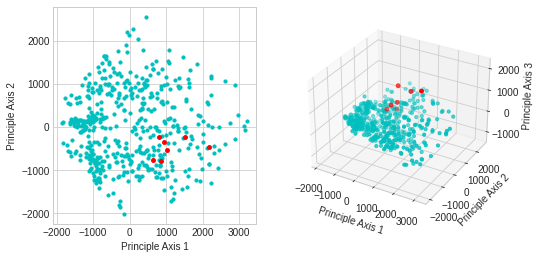

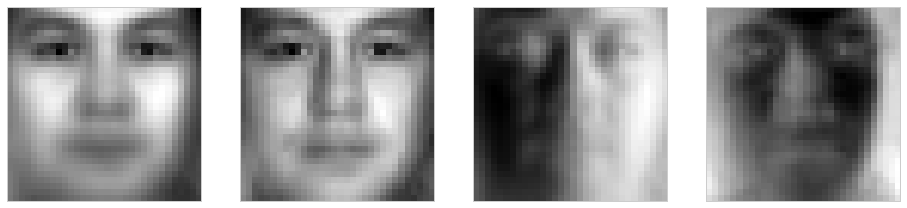

Showing 3 example results here


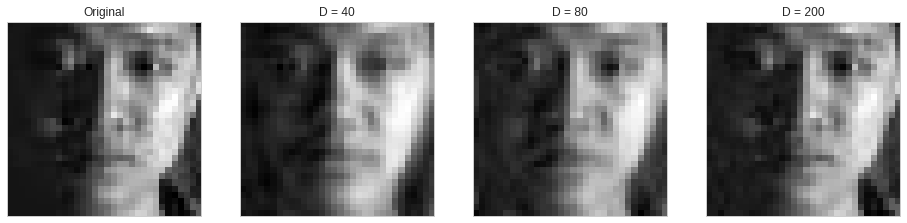

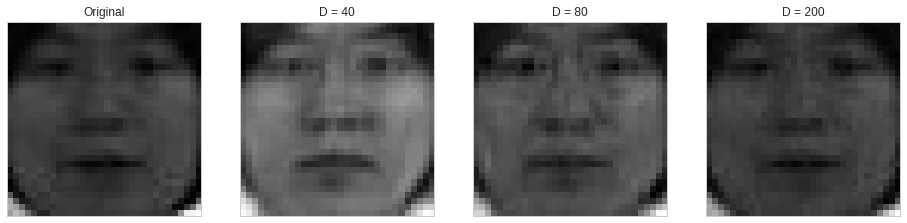

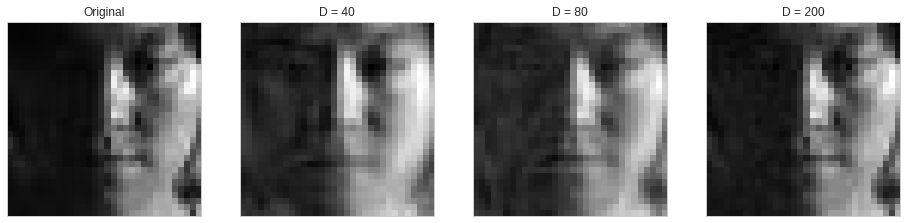

Finished PCA Processing


In [10]:
# Display Settings
show_pca_result = True      # If we want to plot the PCA results
show_num_samples = 3        # Number of example results to display after done, `0` for no output

# Set destination paths
data_path = 'data/'

# Read 500 images from the train set
PIE_train, MY_train = readImageData(data_path, set='train', num_PIE_imgs=500)

# Stack all image vectors together forming X_train set
X_train = np.vstack((PIE_train, MY_train))
img_shape = np.array([np.sqrt(X_train.shape[1]), np.sqrt(X_train.shape[1])], dtype=int)
print(X_train.shape)

# Apply PCA on 3D (which also included 2D) and visualize results
getPCA3Results(X_train, PIE_train, MY_train, img_shape, show_plot=show_pca_result)

# Apply PCA on 40, 80, 200 dimensions and show the reconstructed images
dimensions = [40, 80, 200]
reconstructImgsPCAs(X_train, dimensions, img_shape, show_samples=show_num_samples)

print('Finished PCA Processing')